In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import folium as fo
import json
%matplotlib inline

## LOAD RESOURCES ##

In [3]:
path = 'resources/food-inspections-cleaned.parquet'
df = pd.read_parquet(path)
df.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,None,41.965719,-87.708538,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38


In [4]:
nb_NaN_violations = len(df) - df['Violations'].count()
print("We have {} out of {} inspections with no violations recorded. It makes {}%.".format(nb_NaN_violations, len(df), "%.2f" % (nb_NaN_violations/len(df)*100)))

We have 51070 out of 191827 inspections with no violations recorded. It makes 26.62%.


## EXPLODE VIOLATIONS ##

In [5]:
df_split = df.copy()
df_split['Violations'] = df_split['Violations'].map(lambda x: str(x).split('|'))
df_split.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,[None],41.965719,-87.708538,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...",41.968820,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,Fail,"[38. INSECTS, RODENTS, & ANIMALS NOT PRESENT -...",41.917539,-87.703728,False,LOGAN SQUARE,LOGAN SQUARE,32,22


In [6]:
violations = df_split.explode('Violations').rename(columns={'Violations' : 'Violation'})
violations = violations[violations['Violation'] != 'None']
nb_violations = len(violations)
violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violation,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERC...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,50. HOT & COLD WATER AVAILABLE; ADEQUATE PRES...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38


## GET VIOLATIONS IDS ##

In [7]:
def get_violation_id(x):
    return x.split('.')[0].strip()

violations['Violation ID'] = violations['Violation'].apply(get_violation_id).astype(int)
violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violation,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation ID
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,3
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,5
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERC...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,25
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,50. HOT & COLD WATER AVAILABLE; ADEQUATE PRES...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,50
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,53


In [8]:
violation_id_meaning = pd.read_csv('resources/violation-id-meaning.csv', delimiter=',').set_index('Violation ID')
violation_id_meaning.head()

,Meaning
Violation ID,
1,Suspicious source
2,No adequate food storage
3,Food storage temperature problems
4,Contamination
5,Disease among the staff


In [9]:
violations['Meaning'] = violations['Violation ID'].apply(lambda x: violation_id_meaning.at[x, 'Meaning'] if x in violation_id_meaning.index else None)
violations[['Violation ID', 'Meaning']].head()

,Violation ID,Meaning
1,3,Food storage temperature problems
1,5,Disease among the staff
1,25,Poisonous and toxic materials used in dangerou...
1,50,None
1,53,None


## GET VIOLATIONS SEVERITY ##

In [10]:
def is_violation_high_severity(x):
    return x <= 14

def is_violation_medium_severity(x):
    return 15 <= x and x <= 29

def is_violation_low_severity(x):
    return 30 <= x

def get_violation_severity(x):
    if is_violation_high_severity(x):
        return 'High'
    if is_violation_medium_severity(x):
        return 'Medium'
    return 'Low'

violations['Violation Severity'] = violations['Violation ID'].apply(get_violation_severity)
violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation ID,Meaning,Violation Severity
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,3,Food storage temperature problems,High
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,5,Disease among the staff,High
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,25,Poisonous and toxic materials used in dangerou...,Medium
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,50,None,Low
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,53,None,Low


## SAVE THE VIOLATIONS ORIENTED DATASET ##

In [11]:
violations.to_parquet('resources/violations_oriented.parquet')

## HOW MANY INSPECTIONS DO WE HAVE BY YEAR / MONTH ? ##

Text(0.5, 1.0, 'Number of inspections by year')

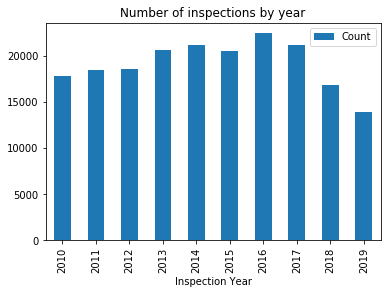

In [21]:
nb_inspections_by_year = df[['Inspection Date', 'Inspection ID']].copy()
nb_inspections_by_year['Inspection Date'] = nb_inspections_by_year['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year = nb_inspections_by_year.groupby('Inspection Year').count().rename(columns={'Inspection ID' : 'Count'})
nb_inspections_by_year.plot.bar()
plt.title("Number of inspections by year")

Text(0.5, 1.0, 'Number of inspections by month')

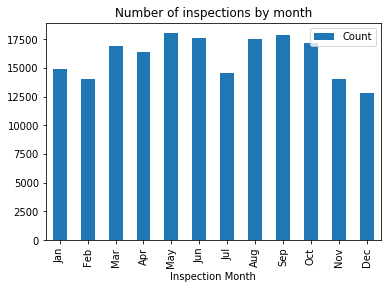

In [22]:
nb_inspections_by_month = df[['Inspection Date', 'Inspection ID']].copy()
nb_inspections_by_month['Inspection Date'] = nb_inspections_by_month['Inspection Date'].apply(lambda x: x.month)
nb_inspections_by_month.rename(columns={'Inspection Date' : 'Inspection Month'}, inplace=True)
nb_inspections_by_month = nb_inspections_by_month.groupby('Inspection Month').count().rename(columns={'Inspection ID' : 'Count'})
nb_inspections_by_month.plot.bar()
plt.gca().set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title("Number of inspections by month")

## WWAT PERCENTAGE OF INSPECTIONS ARE RE-INSPECTIONS ? ##

In [32]:
count_reinspections = df[['Inspection ID', 'Re-inspection']].groupby('Re-inspection').count().rename(columns={'Inspection ID' : 'Count'})
count_reinspections['Percent'] = count_reinspections['Count'] / len(df) * 100
count_reinspections

,Count,Percent
Re-inspection,,
False,155124,80.866614
True,36703,19.133386


From here we will not consider re-inspections since they could bias our analysis.

In [24]:
violations_no_reinspection = violations[violations['Re-inspection'] == False]
violations_no_reinspection.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation ID,Meaning,Violation Severity
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,...,41.917539,-87.703728,False,LOGAN SQUARE,LOGAN SQUARE,32,22,38,Flow of air from kitchen not discharged above ...,Low
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,...,41.917539,-87.703728,False,LOGAN SQUARE,LOGAN SQUARE,32,22,47,None,Low
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,...,41.917539,-87.703728,False,LOGAN SQUARE,LOGAN SQUARE,32,22,53,None,Low
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,...,41.917539,-87.703728,False,LOGAN SQUARE,LOGAN SQUARE,32,22,55,None,Low
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,...,41.917539,-87.703728,False,LOGAN SQUARE,LOGAN SQUARE,32,22,58,None,Low


## WHICH VIOLATIONS ARE THE MOST COMMON ? ##

In [25]:
all_violations_ids = violations_no_reinspection['Violation ID'].unique()
all_violations_ids.sort()
all_violations_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 70])

In [26]:
violations_id_count = violations_no_reinspection[['Inspection ID', 'Violation ID']].groupby('Violation ID').count().rename(columns={'Inspection ID' : 'Count'})
violations_id_count['Meaning'] = violations_id_count.index.to_series().apply(lambda x: violation_id_meaning.at[x, 'Meaning'] if x in violation_id_meaning.index else None)
violations_id_count.sort_values('Count', ascending=False).head(10)

,Count,Meaning
Violation ID,,
34,60584,Floors are not clean
33,54374,Equipment or ustensils not cleaned after each use
35,53686,Walls or ceilings are not clean or not in good...
38,48119,Flow of air from kitchen not discharged above ...
32,45433,Equipment or utensils not easily cleanable or ...
41,29296,Offensive odors / Cleaning equipment not store...
36,23304,Not enough light where food is prepared / No p...
3,16735,Food storage temperature problems
18,15637,No measures against infestations


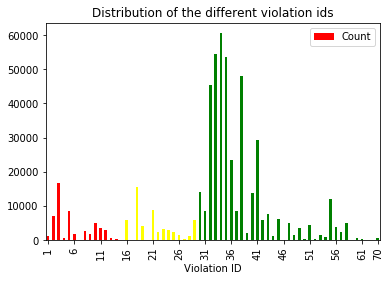

In [27]:
colors = [['red']*14 + ['yellow']*15 + ['green']*(len(violations_id_count) - 14 - 15)]
violations_id_count.plot.bar(color=colors)
plt.title("Distribution of the different violation ids")
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)
xticks[-1].set_visible(True)

## ARE THE VIOLATIONS MOSTLY SEVERE ? ##

In [33]:
violations_severity_count = violations_no_reinspection[['Inspection ID', 'Violation Severity']].groupby('Violation Severity').count().rename(columns={'Inspection ID' : 'Count'})
violations_severity_count['Percent'] = violations_severity_count['Count'].apply(lambda x: "%.3f" % (x/len(violations_no_reinspection)*100))
violations_severity_count

,Count,Percent
Violation Severity,,
High,52327,9.851
Low,424494,79.919
Medium,54337,10.230


Text(0.5, 1.0, 'Distribution of the severity levels for the violations')

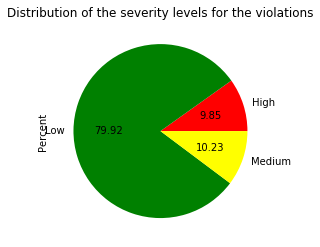

In [34]:
violations_severity_count['Percent'].astype(float).plot.pie(autopct='%.2f', colors=['red', 'green', 'yellow'], fontsize=10)
plt.title("Distribution of the severity levels for the violations")

In [35]:
df_violation_ids = df_split.copy()
df_violation_ids['Violation IDs'] = df_violation_ids['Violations'].apply(lambda violations: [get_violation_id(x) for x in violations])
df_violation_ids['Nb Violations'] = df_violation_ids['Violation IDs'].apply(lambda x: 0 if 'None' in x else len(x))
df_violation_ids[['Violations', 'Violation IDs', 'Nb Violations']].head()

,Violations,Violation IDs,Nb Violations
0,[None],[None],0
1,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...","[3, 5, 25, 50, 53, 53, 56, 58]",8
2,"[38. INSECTS, RODENTS, & ANIMALS NOT PRESENT -...","[38, 47, 53, 55, 58, 60]",6
3,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...","[3, 48, 51, 55, 58]",5
4,[14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TA...,"[14, 25, 41, 47, 48, 55, 56, 57, 58, 60]",10


In [36]:
df_violation_ids['Nb Violations of high severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_high_severity(int(x))]))
df_violation_ids['Nb Violations of medium severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_medium_severity(int(x))]))
df_violation_ids['Nb Violations of low severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_low_severity(int(x))]))
df_violation_ids[['Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
0,0,0,0,0
1,8,2,1,5
2,6,0,0,6
3,5,1,0,4
4,10,1,1,8


Text(0.5, 1.0, 'Distribution of the number of violations by inspection')

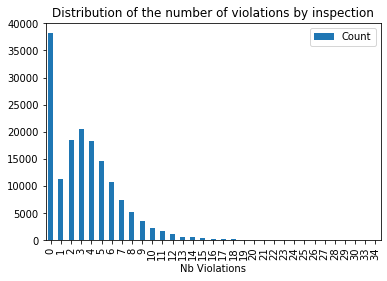

In [41]:
df_violation_ids_no_reinspection = df_violation_ids[df_violation_ids['Re-inspection'] == False]
df_violation_ids_no_reinspection[['Inspection ID', 'Nb Violations']].groupby('Nb Violations').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar()
plt.title("Distribution of the number of violations by inspection")

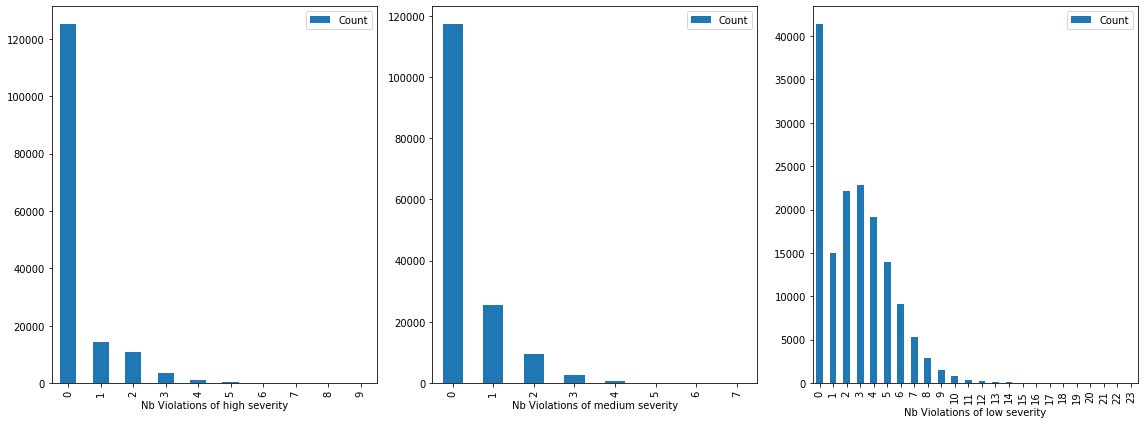

In [42]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
df_violation_ids_no_reinspection[['Inspection ID', 'Nb Violations of high severity']].groupby('Nb Violations of high severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax1)
df_violation_ids_no_reinspection[['Inspection ID', 'Nb Violations of medium severity']].groupby('Nb Violations of medium severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax2)
df_violation_ids_no_reinspection[['Inspection ID', 'Nb Violations of low severity']].groupby('Nb Violations of low severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax3)
plt.tight_layout()

## SAVE THE DATASET EXPANDED WITH MORE INFO ABOUT VIOLATIONS ##

In [39]:
df_violation_ids.to_parquet('resources/extended_dataset.parquet')

## HOW DOES THE NUMBER OF VIOLATIONS VARY OVER TIME ? ##

In [43]:
nb_violations_by_date = df_violation_ids_no_reinspection[['Inspection Date', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Inspection Date').sum()
nb_violations_by_date.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Date,,,,
2010-01-04,16,0,3,13
2010-01-05,221,4,18,199
2010-01-06,264,13,37,214
2010-01-07,170,5,9,156
2010-01-08,116,4,8,104


In [44]:
nb_violations_by_date.sort_values('Nb Violations', ascending=False).head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Date,,,,
2019-04-23,493,117,61,315
2019-02-21,482,134,66,282
2019-05-20,476,125,53,298
2019-02-25,475,130,50,295
2019-06-17,463,113,47,303


Text(0.5, 1.0, 'Variation of the number of violations over inspections')

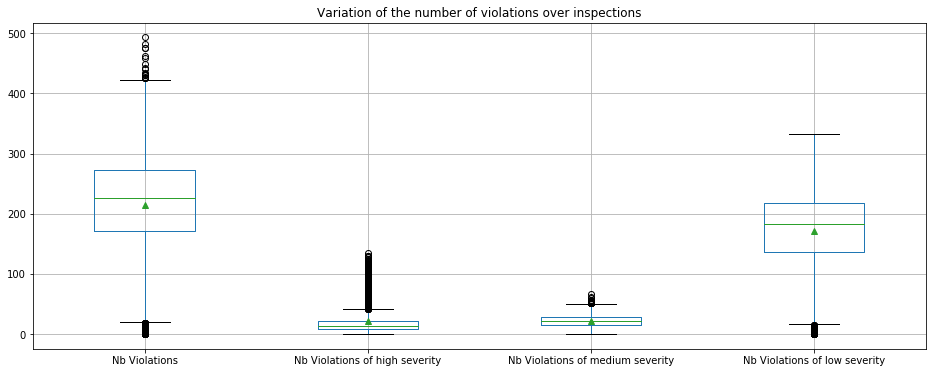

In [45]:
nb_violations_by_date.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("Variation of the number of violations over inspections")

In [46]:
nb_violations_by_year = nb_violations_by_date.copy().reset_index()
nb_violations_by_year['Inspection Date'] = nb_violations_by_year['Inspection Date'].apply(lambda x: x.year)
nb_violations_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_violations_by_year = nb_violations_by_year.groupby('Inspection Year').mean()
nb_violations_by_year.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Year,,,,
2010,181.675472,11.456604,16.135849,154.083019
2011,208.434783,11.794466,18.992095,177.648221
2012,190.047059,11.509804,18.854902,159.682353
2013,205.273092,11.465863,20.068273,173.738956
2014,226.888889,14.357143,21.202381,191.329365


Text(0.5, 1.0, 'Mean number of violations by inspection for each year')

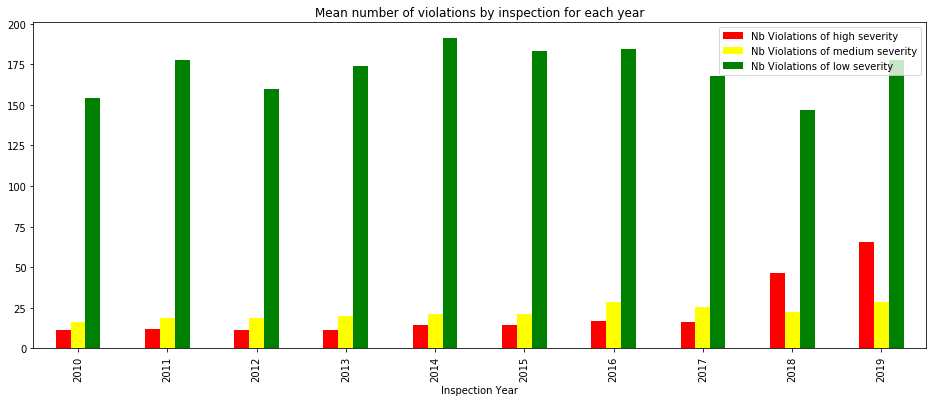

In [47]:
nb_violations_by_year[['Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].plot.bar(color=['red', 'yellow', 'green'], figsize=(16,6))
plt.title("Mean number of violations by inspection for each year")

## WHICH FACILITIY TYPES HAVE MORE VIOLATIONS ? ##

In [48]:
mean_nb_violations_by_facility = df_violation_ids_no_reinspection[['Facility Type', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Facility Type').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_facility.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Facility Type,,,,
Long term care center,4.237579,0.476965,0.392051,3.368564
Bakery,3.943231,0.345415,0.362445,3.235371
Restaurant,3.675696,0.370839,0.374384,2.930473
Grocery store,3.630098,0.328505,0.395429,2.906163
Gas station,3.603774,0.383648,0.421384,2.798742


In [49]:
mean_nb_violations_by_facility.sort_values('Nb Violations').head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Facility Type,,,,
Unknown,0.080580,0.012151,0.008740,0.059689
Shared kitchen,0.825342,0.071918,0.075342,0.678082
Mobile food dispenser,1.282110,0.389908,0.215596,0.676606
Rooftop,1.795455,0.303030,0.136364,1.356061
Coffee shop,1.892857,0.250000,0.185714,1.457143


Text(0.5, 1.0, 'Variation of the mean number of violations by facility type')

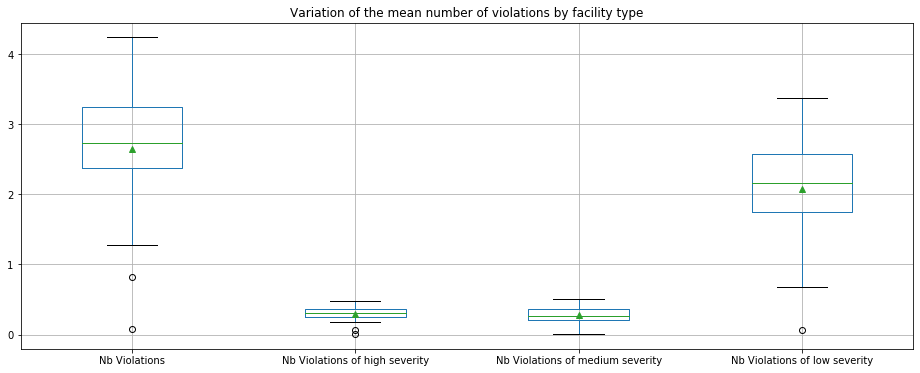

In [50]:
mean_nb_violations_by_facility.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("Variation of the mean number of violations by facility type")

## WHICH COMMUNITES HAVE MORE VIOLATIONS ? ##

In [51]:
mean_nb_violations_by_community = df_violation_ids_no_reinspection[['Community', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Community').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_community.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Community,,,,
WEST RIDGE,4.362032,0.416845,0.429679,3.515508
SOUTH LAWNDALE,4.234606,0.414409,0.438732,3.381466
NORTH PARK,4.139660,0.371914,0.356481,3.411265
WASHINGTON PARK,4.118393,0.397463,0.562368,3.158562
HYDE PARK,4.107520,0.446240,0.418272,3.243008


In [52]:
mean_nb_violations_by_community.sort_values('Nb Violations').head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Community,,,,
NEAR SOUTH SIDE,2.721331,0.332739,0.274510,2.114082
LOOP,2.788435,0.292631,0.244305,2.251499
GARFIELD RIDGE,2.795533,0.219931,0.235395,2.340206
RIVERDALE,2.798611,0.159722,0.361111,2.277778
EAST SIDE,2.810580,0.257679,0.257679,2.295222


Text(0.5, 1.0, 'Variation of the mean number of violations by facility type')

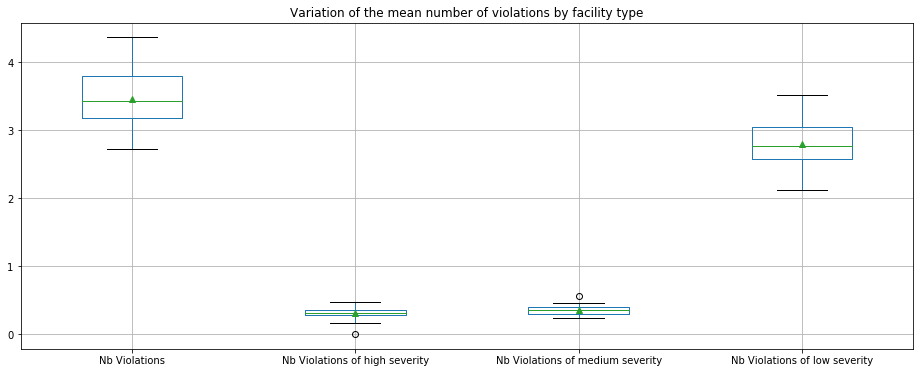

In [53]:
mean_nb_violations_by_community.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("Variation of the mean number of violations by facility type")

In [54]:
m_violations = fo.Map(location=[41.8281136,-87.6297982], zoom_start=10, zoom_control=False)
nds = pd.DataFrame()
nds['Community'] = mean_nb_violations_by_community.index.astype('str')
nds['Nb Violations'] = mean_nb_violations_by_community['Nb Violations'].values
fe1 = fo.Choropleth(
    geo_data='resources/geojsons/chicago-community.geojson',
    name='Violations by communities',
    data=nds,
    columns=['Community', 'Nb Violations'],
    key_on='properties.community',
    fill_color='Reds',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name=' Mean of number of violations by community (in %)'
)
fe1.add_to(m_violations)
m_violations

## HOW MUCH FAILING AN INSPECTION IS LINKED TO THE NUMBER OF VIOLATIONS ? ##

In [54]:
mean_nb_violations_by_result = df_violation_ids_no_reinspection[['Results', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Results').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_result.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Results,,,,
Fail,5.876186,0.712516,1.196146,3.967524
Pass w/ Conditions,5.407404,1.241328,0.594660,3.571416
Pass,2.809281,0.003976,0.002888,2.802418
No Entry,0.119362,0.003087,0.001715,0.114560
Not Ready,0.060369,0.010061,0.006708,0.043600


In [57]:
mean_nb_violations_by_result_and_reinspection = df_violation_ids[['Results', 'Re-inspection', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby(['Results', 'Re-inspection']).mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_result_and_reinspection

Nb Violations  \
Results              Re-inspection                  
Fail                 False               5.876186   
Not Ready            True                5.428571   
Pass w/ Conditions   False               5.407404   
Fail                 True                5.306931   
Pass w/ Conditions   True                5.195188   
No Entry             True                4.383041   
Pass                 False               2.809281   
                     True                1.719682   
Out of Business      True                0.604167   
No Entry             False               0.119362   
Not Ready            False               0.060369   
Out of Business      False               0.002355   
Business Not Located False               0.000000   

                                    Nb Violations of high severity  \
Results              Re-inspection                                   
Fail                 False                                0.712516   
Not Ready            True                                 1.371429   
Pass w/ Conditions   False                                1.241328   
Fail                 True                                 0.805174   
Pass w/ Conditions   True                                 1.183780   
No Entry             True                                 0.330409   
Pass                 False                                0.003976   
                     True                                 0.004610   
Out of Business      True                                 0.010417   
No Entry             False                                0.003087   
Not Ready            False                                0.010061   
Out of Business      False                                0.000060   
Business Not Located False                                0.000000   

                                    Nb Violations of medium severity  \
Results              Re-inspection                                     
Fail                 False                                  1.196146   
Not Ready            True                                   0.657143   
Pass w/ Conditions   False                                  0.594660   
Fail                 True                                   0.747684   
Pass w/ Conditions   True                                   0.586062   
No Entry             True                                   1.023392   
Pass                 False                                  0.002888   
                     True                                   0.005470   
Out of Business      True                                   0.125000   
No Entry             False                                  0.001715   
Not Ready            False                                  0.006708   
Out of Business      False                                  0.000121   
Business Not Located False                                  0.000000   

                                    Nb Violations of low severity  
Results              Re-inspection                                 
Fail                 False                               3.967524  
Not Ready            True                                3.400000  
Pass w/ Conditions   False                               3.571416  
Fail                 True                                3.754072  
Pass w/ Conditions   True                                3.425347  
No Entry             True                                3.029240  
Pass                 False                               2.802418  
                     True                                1.709602  
Out of Business      True                                0.468750  
No Entry             False                               0.114560  
Not Ready            False                               0.043600  
Out of Business      False                               0.002174  
Business Not Located False                               0.000000

## WHICH INSPECTION TYPES GIVE MORE VIOLATIONS ? ##

In [58]:
mean_nb_violations_by_inspection_type = df_violation_ids_no_reinspection[['Inspection Type', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Inspection Type').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_inspection_type

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Type,,,,
Suspect food poisoning,5.001208,0.711353,0.507246,3.782609
Complaint,4.429702,0.458496,0.488334,3.482872
Canvass,3.412136,0.306883,0.327308,2.777945
Others,3.129543,0.164026,0.171482,2.794035
License,2.556591,0.346744,0.314810,1.895037
Consultation,2.434655,0.099853,0.221733,2.113069
Task-force,2.352877,0.301846,0.398480,1.652552
Cancelled,0.125749,0.000000,0.017964,0.107784
Unknown,0.000000,0.000000,0.000000,0.000000


## DO THE RISKY ENVIRONNEMENTS HAVE LESS/MORE VIOLATIONS ? ##

In [59]:
mean_nb_violations_by_risk = df_violation_ids_no_reinspection[['Risk', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Risk').mean().sort_values('Nb Violations', ascending=False)
mean_nb_violations_by_risk

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Risk,,,,
High,3.728862,0.373696,0.365723,2.989444
Medium,3.046947,0.281287,0.348510,2.417150
Low,1.796921,0.167207,0.230333,1.399381
All,0.000000,0.000000,0.000000,0.000000


## CAN WE SEE PERIODS OF INFESTATIONS FROM THE VIOLATIONS ? ##

Text(0.5, 1.0, 'Mean number of infestations by inspection for each year')

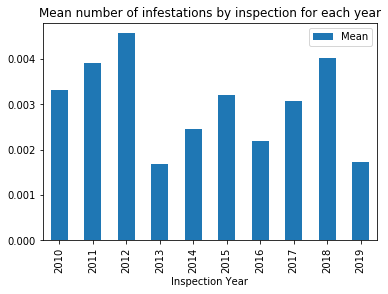

In [60]:
def intersection(list1, list2):
    return list(set(list1) & set(list2))

def analyse_frequency_violations(ids, all_ids_must_appear=False):
    result = df_violation_ids_no_reinspection[['Inspection Date', 'Violation IDs']].copy()
    result['Inspection Date'] = result['Inspection Date'].apply(lambda x: x.year)
    result.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
    if all_ids_must_appear:
        result['Qualify'] = result['Violation IDs'].apply(lambda x: 1 if len(intersection(ids, x)) == len(ids) else 0)
    else:
        result['Qualify'] = result['Violation IDs'].apply(lambda x: 1 if len(intersection(ids, x)) > 0 else 0)
    result = result.groupby('Inspection Year').mean().rename(columns={'Qualify' : 'Mean'})
    return result

nb_infestations_by_year = analyse_frequency_violations(['13'])
nb_infestations_by_year.plot.bar()
plt.title("Mean number of infestations by inspection for each year")

Sadly, it seems that we cannot see the rodent invastion from the number of 'infestations' violations ! https://southsideweekly.com/i-smell-a-rat/

## CAN WE SEE OTHER VIOLATIONS' FREQUENCY THAT VARY OVER YEARS ? ##

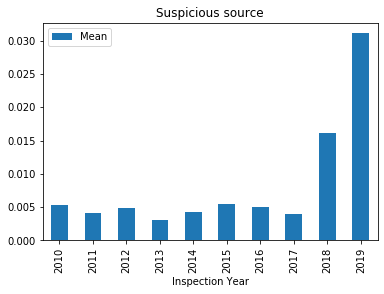

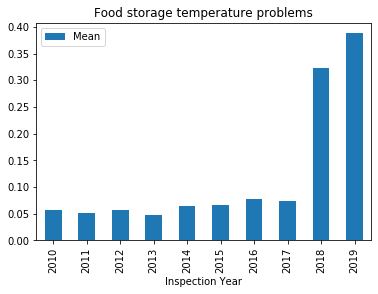

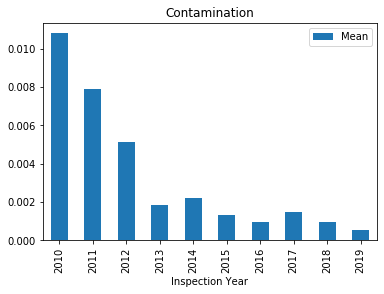

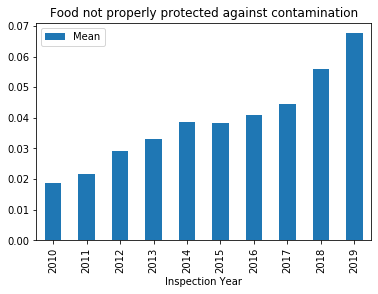

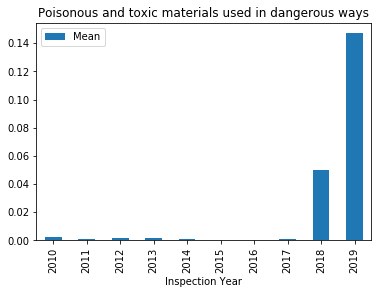

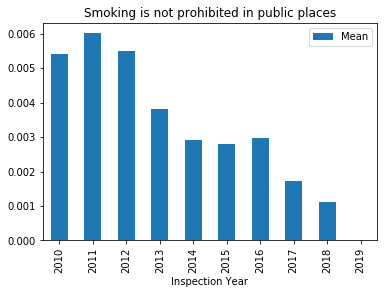

In [61]:
interesting_ids = [1, 3, 4, 16, 25, 70]
for violation_id in interesting_ids:
    analyse_by_year = analyse_frequency_violations([str(violation_id)])
    analyse_by_year.plot.bar()
    plt.title(violation_id_meaning.loc[violation_id][0])

The violation's types vary over years. For example, the food storage temperature problems and poisonous/toxic problems are more common nowadays than before (maybe because of the [global warming and pollution]() ). I contrast, Smoking is prohibited in public places so this violations decrease slowly over the last 10 years.